In [1]:
import numpy as np
import xarray as xr
from matplotlib.path import Path
import proplot as plot
import cartopy.crs as ccrs
from cartopy.io.shapereader import Reader
from cartopy.mpl.patch import geos_to_path
from cartopy.feature import ShapelyFeature
import cmaps

ds = xr.open_dataset('gfs.t12z.pgrb2.0p25.f000',engine="cfgrib",backend_kwargs={'filter_by_keys':{'typeOfLevel':'heightAboveGround','level':2},'indexpath':''})
ds = ds.drop(["time","heightAboveGround","step"])
ds.rename({'valid_time':'time'})
ds = ds.reindex(latitude=ds.latitude[::-1])
ds = ds.sel(longitude=slice(70,135),latitude=slice(15,60))
ds

<xarray.Dataset>
Dimensions:     (latitude: 181, longitude: 261)
Coordinates:
  * latitude    (latitude) float64 15.0 15.25 15.5 15.75 ... 59.5 59.75 60.0
  * longitude   (longitude) float64 70.0 70.25 70.5 70.75 ... 134.5 134.8 135.0
    valid_time  datetime64[ns] 2021-01-15T12:00:00
Data variables:
    t2m         (latitude, longitude) float32 ...
    q           (latitude, longitude) float32 ...
    d2m         (latitude, longitude) float32 ...
    r2          (latitude, longitude) float32 ...
    aptmp       (latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             kwbc
    GRIB_centreDescription:  US National Weather Service - NCEP 
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             US National Weather Service - NCEP 
    history:                 2021-01-30T17:17:48 GRIB to CDM+CF via cfgrib-0....

(<cartopy.mpl.feature_artist.FeatureArtist at 0x1a5a9c9b908>,
 <cartopy.mpl.feature_artist.FeatureArtist at 0x1a5a9cba5f8>)

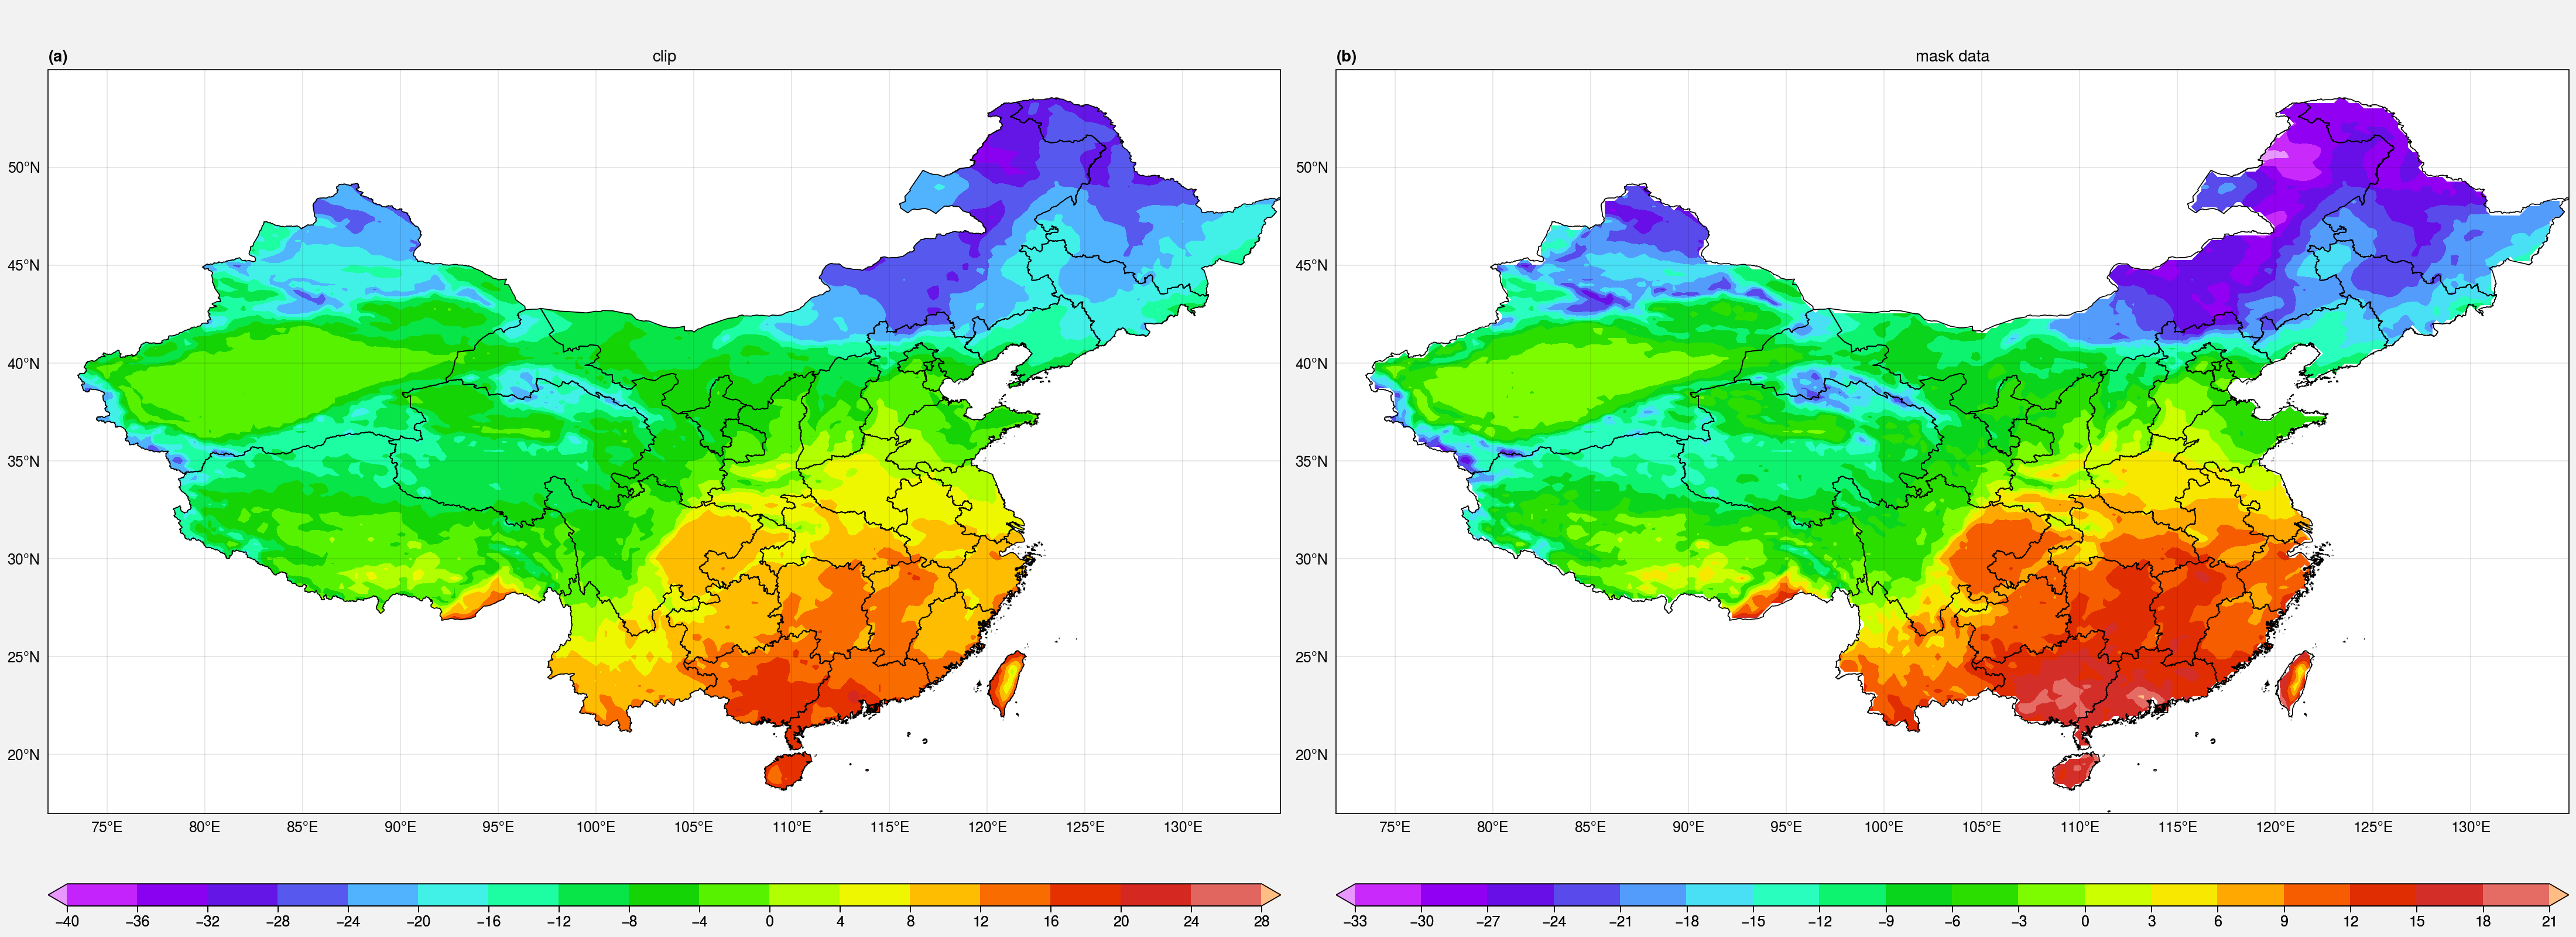

In [5]:
# fname = 'shapefile/chn_adm_ocha_2020_shp/chn_admbnda_adm1_ocha_2020.shp'
fname = 'china-shapefiles-master/shapefiles/china.shp'
shape_records = Reader(fname).records()
geoms = []
for country in shape_records:
    geoms +=  country.geometry 
path = Path.make_compound_path(*geos_to_path(geoms))

X, Y = np.meshgrid(ds.longitude.values,ds.latitude.values)
points = np.array((X.flatten(), Y.flatten())).T
mask = path.contains_points(points).reshape(X.shape)
mask_t2m = ds.t2m.copy(deep=True)
mask_t2m.values[ mask == False] = np.nan

f, axs = plot.subplots(ncols=2, nrows=1, figsize=(22,8),proj='pcarree' )
axs.format(
    labels=True,latlines=5, lonlines=5,lonlim=(72,135),latlim=(17,55),
    abc=True,abcloc='l', abcstyle='(a)',
    suptitle=''
)
 
im = axs[0].contourf(ds.longitude, ds.latitude, ds.t2m -273.15, cmap=cmaps.NCV_bright, levels=21, extend='both')
for collection in im.collections:
    collection.set_clip_path(path, ccrs.PlateCarree()._as_mpl_transform(axs[0]))
axs[0].colorbar(im, loc='b', length=1)
axs[0].format(title='clip')

im = axs[1].contourf(ds.longitude, ds.latitude, mask_t2m -273.15, cmap=cmaps.NCV_bright,levels=21, extend='both')
axs[1].colorbar(im, loc='b', length=1)
axs[1].format(title='mask data')

shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                ccrs.PlateCarree(), facecolor='none',edgecolor='k')
axs.add_feature(shape_feature)
# axs.coastlines('50m', linewidth=0.8)